In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)


test = pd.read_csv('https://clck.ru/Tgr8u')
train = pd.read_csv('https://clck.ru/Tgr8H')
data = train.append(test, ignore_index=True)

В соответствии с приказом капитана корабля и, принимая во внимание расположение кабин различных классов
(кабины первого класса находились на верхних палубах, второго - ниже, третьего - в самом низу),
предполагаем, что в основном выживали дети, а также женщины, расположившиеся в кабинах 1 и 2 классов.

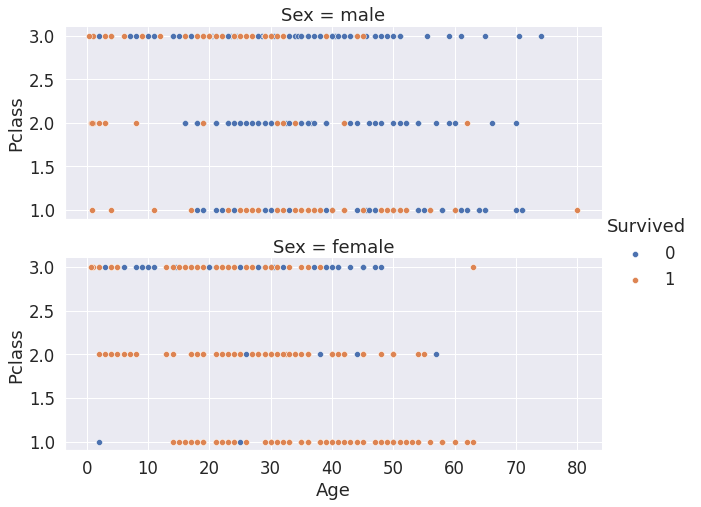

In [2]:
g = sns.FacetGrid(train, row='Sex', hue='Survived')
g.map_dataframe(sns.scatterplot, x='Age', y='Pclass')
g.set_axis_labels('Age', 'Pclass')
g.fig.set_size_inches(10,7)
g.add_legend()
plt.show()

Предположение подтверждается

Оценим полноту данных

In [3]:
print(train.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pcl

Пропуски в признаках: Embarked, Cabin, Age, Fare.



Популярность точек отправления:

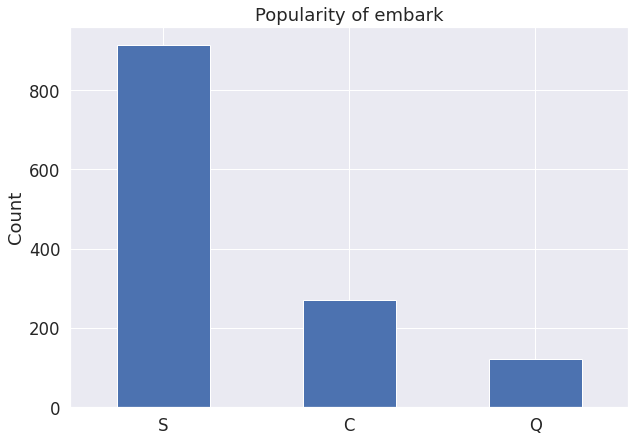

In [5]:
data['Embarked'].value_counts().plot(kind='bar')
plt.title('Popularity of embark')
plt.ylabel('Count')
plt.rcParams.update({'font.size': 16, 'figure.figsize': (10, 7)})
plt.xticks(rotation=0)
plt.show()

В связи с малым количеством пропусков, заполним их наиболее популярным местом отправления:

In [6]:
data['Embarked'].fillna(data['Embarked'].mode(), inplace=True)

Для большинства сэмплов не указан номер кабины. На основании исторических сведений -
номера кабин пассажиров первого класса известны из списка, обнаруженного на теле работника Титаника -
предполагаем корреляцию между выживаемостью пассажиров второго и третьего классов и наличием в их сэмплах номеров кабин.
Введем признак, характеризующий наличие в сэмпле номера кабины, - isCabin:

In [7]:
def fill_is_cabin(data):
    is_cabin = []
    for x in data['Cabin']:
        if pd.isna(x):
            is_cabin.append(0)
        else:
            is_cabin.append(1)
    return is_cabin


data['isCabin'] = fill_is_cabin(data)
train['isCabin'] = fill_is_cabin(train)

Отсеим пассажиров первого класса:

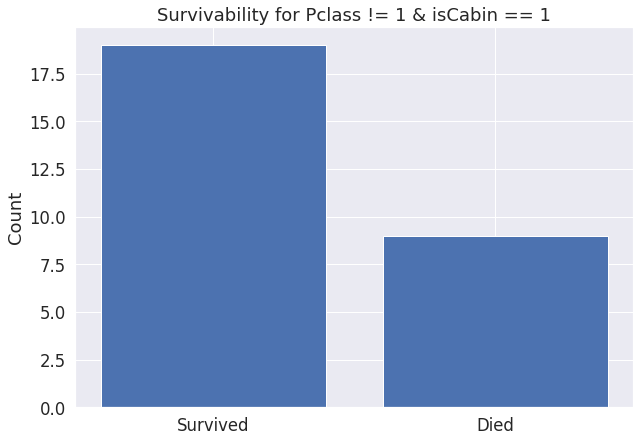

In [8]:
plt.bar(['Survived', 'Died'], train[(train['Pclass'] != 1) & (train['isCabin'] == 1)]['Survived'].value_counts())
plt.title('Survivability for Pclass != 1 & isCabin == 1')
plt.ylabel('Count')
plt.rcParams.update({'font.size': 16, 'figure.figsize': (10, 7)})
plt.show()

Предположение подтверждается -
пассажиры второго и третьего классов с указанными номерами кабин в основном выжили
=> оставляем признак isCabin, дропаем признак Cabin:

In [9]:
data.drop('Cabin', axis=1, inplace=True)

Age заполним средними значениями возраста по гоноративам (Mr, Miss, Master...), содержащимися в признаке Name

In [10]:
data['Title'] = data['Name'].str.split(', ', expand=True)[1].str.split(' ', expand=True)[0]
honorifics = data[pd.isna(data['Age'])]['Title'].value_counts().keys().to_numpy()


def fill_age_by_honorific(data, honorifics):
    for honorific in honorifics:
        nan_indices = []
        age_sum = 0
        counter = 0
        for i in range(len(data)):
            if honorific in data.iloc[i]['Name']:
                if pd.isna(data.iloc[i]['Age']):
                    nan_indices.append(i)
                else:
                    age_sum += data.iloc[i]['Age']
                    counter += 1

        if len(nan_indices):
            mean_age = round(age_sum / counter, 2)
            print(honorific, mean_age)
            for i in nan_indices:
                data.at[i, 'Age'] = mean_age


fill_age_by_honorific(data, honorifics)

Mr. 32.25
Miss. 21.77
Mrs. 36.99
Master. 5.48
Ms. 28.0
Dr. 43.57


https://www.populationspast.org/f_smam/1911/#9/50.8580/-1.4378
25.47 - Средний возраст женщин, вступающих в брак (Miss),
в 1911 году в наиболее популярном месте отправления (Southampton).
       
       Средний возраст Miss по датасету правдоподобен.
Средний возраст замужней женщины > аналогичного параметра незамужней женщины
      
       Средний возраст Mrs по датасету правдоподобен.
Гоноратив Master употребляется для обращения к ребенку мужского пола.
      
       Средний возраст Master по датасету правдоподобен.
Средний возраст женщины с неизвестным семейным положением ~= среднему арифметическому между средними возрастами состоящих и не состоящих в браке женщин.
       
       Средний возраст Ms по датасету правдоподобен.
Средний возраст доктора > аналогичного параметра "просто" мистера.
       
       Средний возраст Dr по датасету правдоподобен.

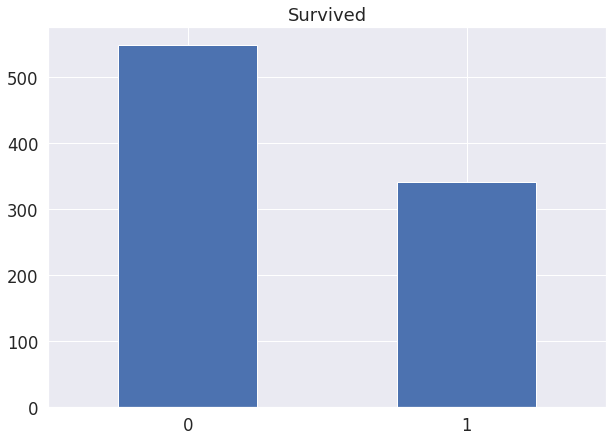

In [11]:
train['Survived'].value_counts().plot(kind='bar', title='Survived')
plt.rcParams.update({'font.size': 16, 'figure.figsize': (10, 7)})
plt.xticks(rotation=0)
plt.show()

Большинство пассажиров погибли

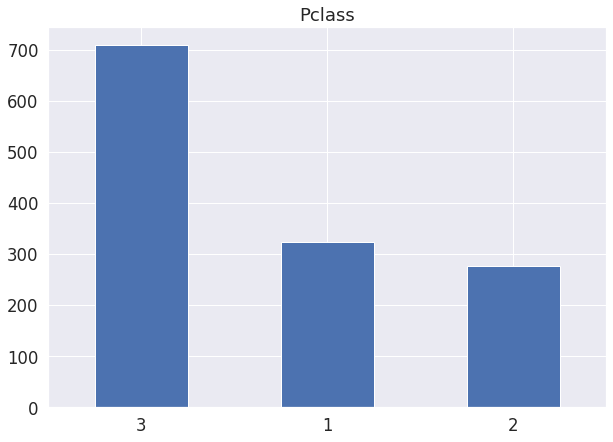

In [12]:
data['Pclass'].value_counts().plot(kind='bar', title='Pclass')
plt.rcParams.update({'font.size': 16, 'figure.figsize': (10, 7)})
plt.xticks(rotation=0)
plt.show()

Большинство пассажиров расположились в 3 классе

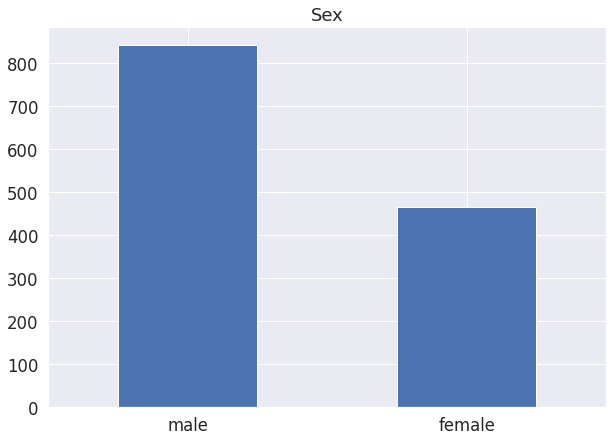

In [13]:
data['Sex'].value_counts().plot(kind='bar', title='Sex')
plt.rcParams.update({'font.size': 16, 'figure.figsize': (10, 7)})
plt.xticks(rotation=0)

plt.show()

Большинство пассажиров составляли мужчины

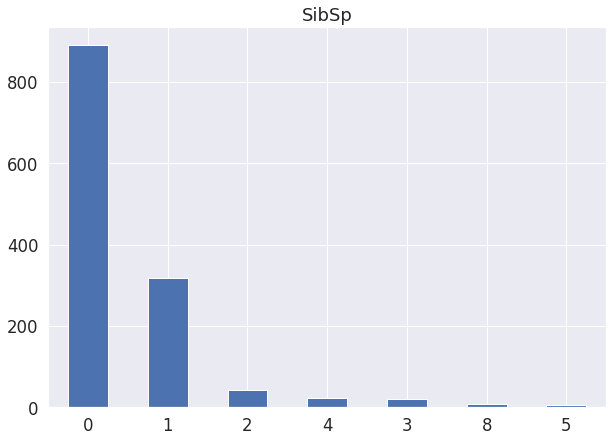

In [14]:
data['SibSp'].value_counts().plot(kind='bar', title='SibSp')
plt.rcParams.update({'font.size': 16, 'figure.figsize': (10, 7)})
plt.xticks(rotation=0)
plt.show()

У большинства пассажиров на борту не было братьев и сестер

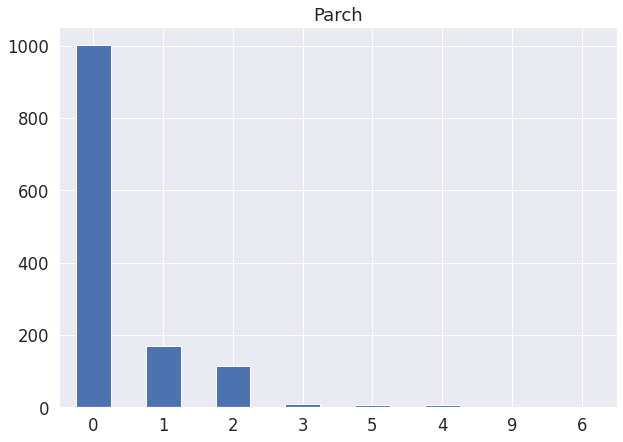

In [15]:
data['Parch'].value_counts().plot(kind='bar', title='Parch')
plt.rcParams.update({'font.size': 16, 'figure.figsize': (10, 7)})
plt.xticks(rotation=0)
plt.show()

У большинства пассажиров на борту не было родителей

In [16]:
print(data[data['Fare'] == 0]['Fare'])

179     0.0
263     0.0
271     0.0
277     0.0
302     0.0
413     0.0
466     0.0
481     0.0
597     0.0
633     0.0
674     0.0
732     0.0
806     0.0
815     0.0
822     0.0
1157    0.0
1263    0.0
Name: Fare, dtype: float64


Есть билеты с нулевой ценой. Заменим нулевые и NaN значения средними значениями по классу кабин:

In [17]:
def fill_fare_by_class(data):
    for i in range(len(data)):
        if data.iloc[i]['Fare'] == 0 or pd.isna(data.iloc[i]['Fare']):
            fill_indices = []
            fare_sum = 0
            counter = 0

            Pclass = data.iloc[i]['Pclass']
            for j in range(len(data)):
                if data.iloc[j]['Pclass'] == Pclass:
                    if data.iloc[j]['Fare'] == 0 or pd.isna(data.iloc[j]['Fare']):
                        fill_indices.append(j)
                    else:
                        fare_sum += data.iloc[j]['Fare']
                        counter += 1

            mean_fare = round(fare_sum / counter, 2)
            for k in fill_indices:
                data.at[k, 'Fare'] = mean_fare


fill_fare_by_class(data)

Введем признак isRelatives, характеризующий наличие родственников на борту:

In [18]:
def fill_is_relatives(data):
    is_relatives = []
    for i in range(len(data)):
        if data.iloc[i]['Parch'] + data.iloc[i]['SibSp'] != 0:
            is_relatives.append(1)
        else:
            is_relatives.append(0)
    return is_relatives


data['isRelatives'] = fill_is_relatives(data)

Преобразуем str в number:

In [19]:
data.replace(['male', 'female'], [1, 0], inplace=True)

One hot encoding:


In [20]:
one_hot = pd.get_dummies(data['Embarked'], prefix='Embarked', dtype='int64')
data = pd.concat([data, one_hot], axis=1)

Отберем полезные признаки и сохраним датасеты:

In [21]:
train = pd.DataFrame(data.iloc[:len(train)])
test = pd.DataFrame(data.iloc[len(train):])
test.drop('Survived', axis=1, inplace=True)

train_features_to_model = ['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
                           'isCabin', 'isRelatives', 'Embarked_C', 'Embarked_Q', 'Embarked_S']
train = train[train_features_to_model]
train_x = train.drop('Survived', axis=1)
print(train_x.info())
train_y = train[['Survived']]
train_x.to_csv('titanic_train_x.csv', index=False)
train_y.to_csv('titanic_train_y.csv', index=False)


test_features_to_model = ['PassengerId', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
                          'isCabin', 'isRelatives', 'Embarked_C', 'Embarked_Q', 'Embarked_S']
test = test[test_features_to_model]
print(test.info())
test.to_csv('titanic_test.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Pclass       891 non-null    int64  
 1   Sex          891 non-null    int64  
 2   Age          891 non-null    float64
 3   SibSp        891 non-null    int64  
 4   Parch        891 non-null    int64  
 5   Fare         891 non-null    float64
 6   isCabin      891 non-null    int64  
 7   isRelatives  891 non-null    int64  
 8   Embarked_C   891 non-null    int64  
 9   Embarked_Q   891 non-null    int64  
 10  Embarked_S   891 non-null    int64  
dtypes: float64(2), int64(9)
memory usage: 76.7 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 891 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Sex         